In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Define the number of classes (KITTI has 8 classes including background)
num_classes = 8

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Ensure the final layer's parameters are trainable (not strictly necessary, but ensures correctness)
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

In [4]:
#Datasets Configuration

import os
import torch
import torchvision.transforms as T
from PIL import Image

class KITTIDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Initialize the dataset with the root directory and transformations
        self.root = root
        self.transforms = transforms
        # List of image file names
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        # List of label file names
        self.anns = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        # Load an image and its corresponding bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "labels", self.anns[idx])
        img = Image.open(img_path).convert("RGB")

        # Parse the annotation file
        with open(ann_path, 'r') as f:
            data = f.readlines()

        boxes = []
        labels = []

        for line in data:
            parts = line.strip().split()
            class_name = parts[0]
            bbox = list(map(float, parts[4:8]))  # Extract bounding box coordinates

            if class_name in KITTI_CLASSES:
                labels.append(KITTI_CLASSES.index(class_name))  # Convert class name to index
                boxes.append(bbox)

        # Convert lists to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create a target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Apply transformations to the image
        if self.transforms is not None:
            img = self.transforms(img)


        return img, target

    def __len__(self):
        # Return the number of images
        return len(self.imgs)

# Define the class names as per KITTI dataset
KITTI_CLASSES = ['__background__', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

def get_transform():
    # Define the transformations to apply
    transforms = [
        # T.Resize((800, 1333)),  # Resize the image to (800, 1333)
        T.ToTensor(),  # Convert PIL image to tensor
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
    ]
    return T.Compose(transforms)

# Create the dataset
dataset = KITTIDataset(root='/content/drive/MyDrive/Object Detection of Images CV Project', transforms=get_transform())


#Testing the Dataset
img, target = dataset[0]  # Load the first image and its target
print(img.shape)  # Should print the shape of the image tensor
# print(f"Image ID: {image_id}")
print(target)  # Should print the target dictionary containing boxes and labels



torch.Size([3, 370, 1224])
{'boxes': tensor([[712.4000, 143.0000, 810.7300, 307.9200]]), 'labels': tensor([4])}


In [5]:
#Train_Test split and DataLoaders

from torch.utils.data import DataLoader, random_split

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

# Define data loaders
data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
#Training Visualization Function

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image(image, target=None, prediction=None):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    image = image.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
    ax.imshow(image.cpu().numpy())

    if target is not None:
        for box in target['boxes']:
            x, y, w, h = box.cpu().numpy()
            rect = patches.Rectangle((x, y), w-x, h-y, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

    if prediction is not None:
        for box in prediction['boxes']:
            x, y, w, h = box.cpu().numpy()
            rect = patches.Rectangle((x, y), w-x, h-y, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

    plt.show()


Epoch 1/10:   0%|          | 0/76 [01:03<?, ?it/s, loss=2.96]

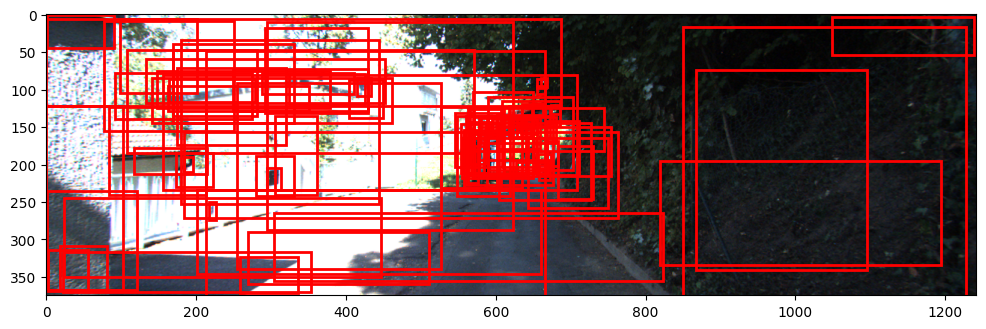

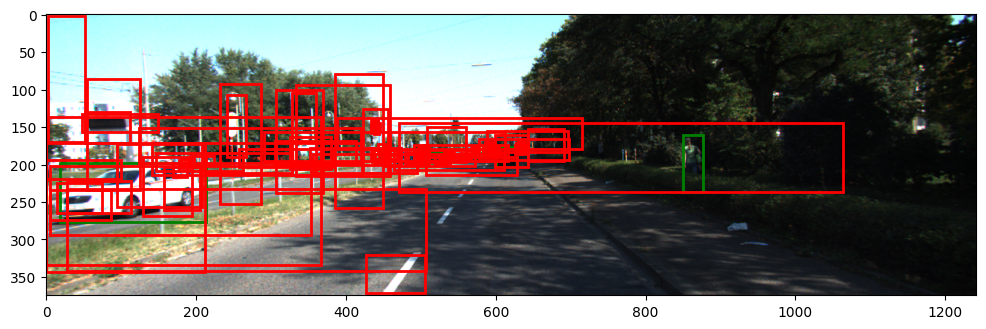

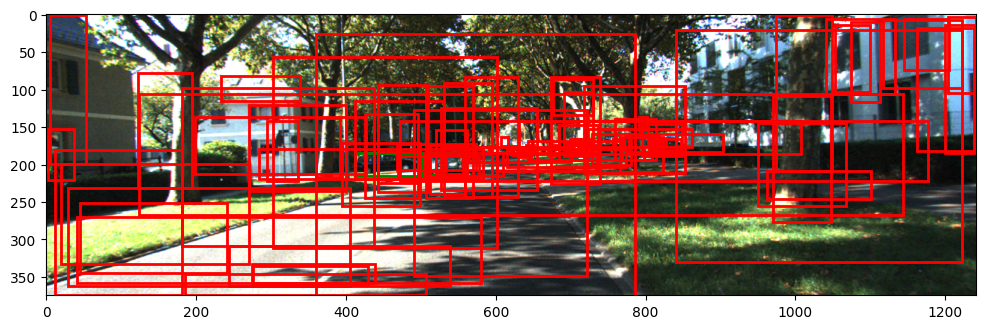

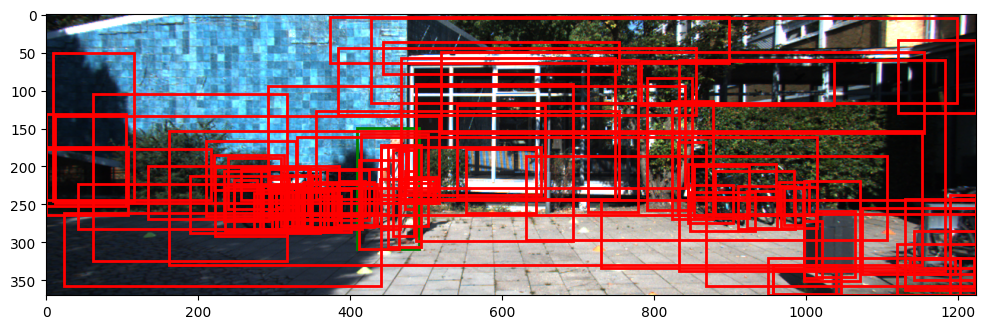

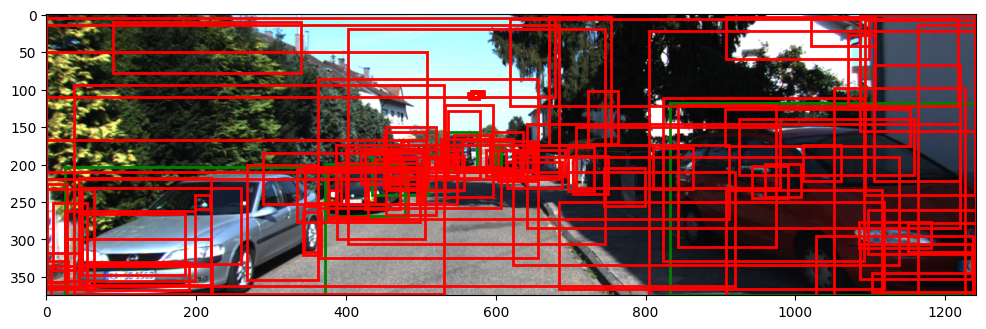

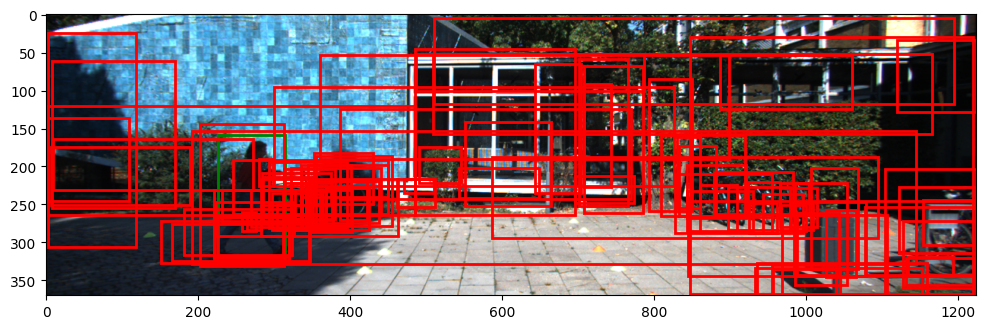

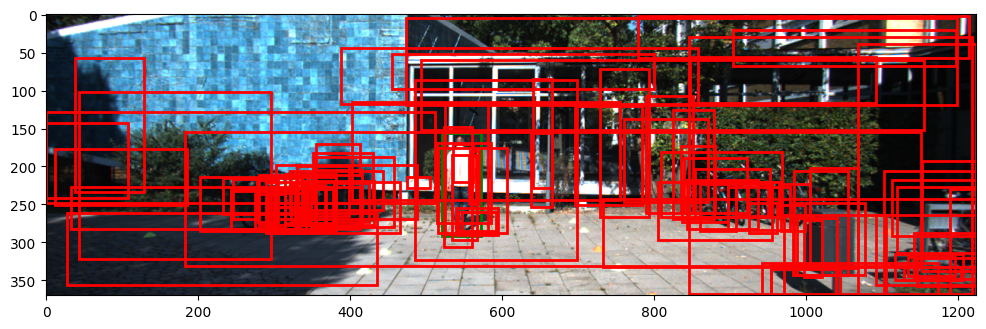

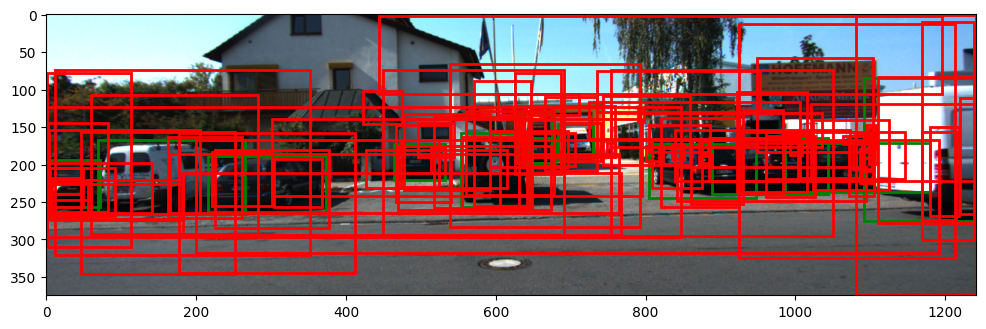

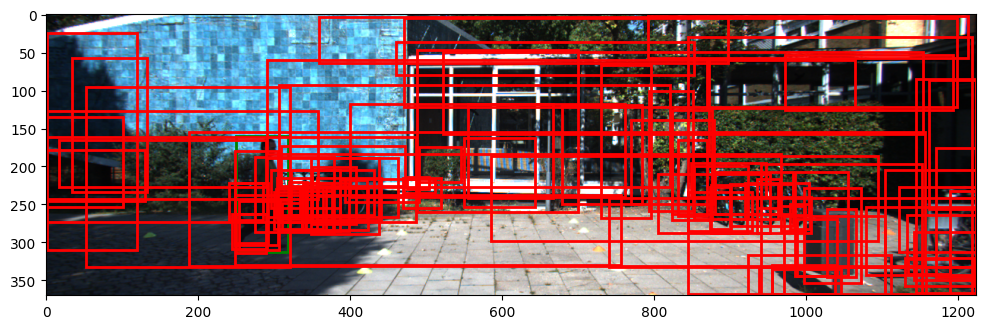

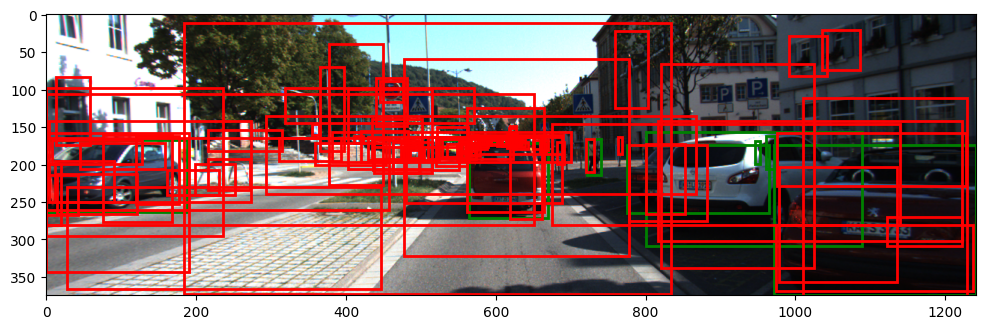

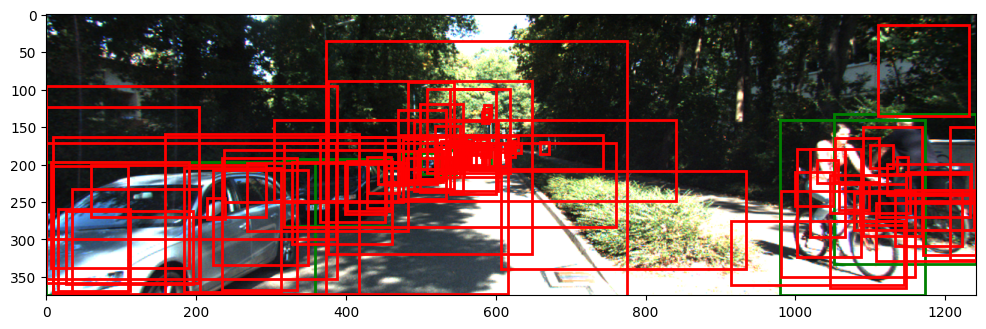

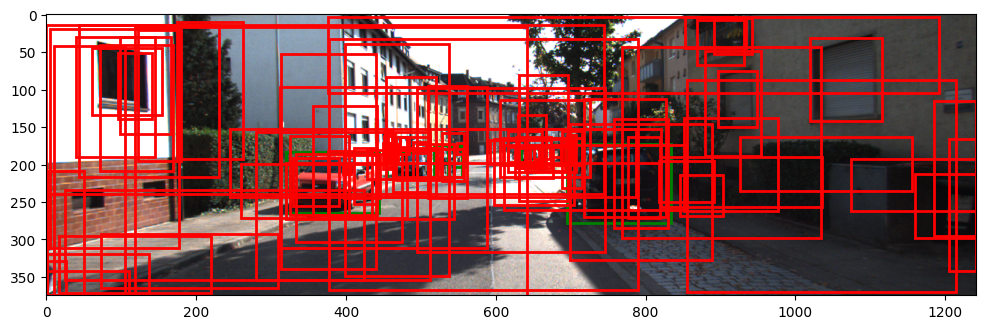

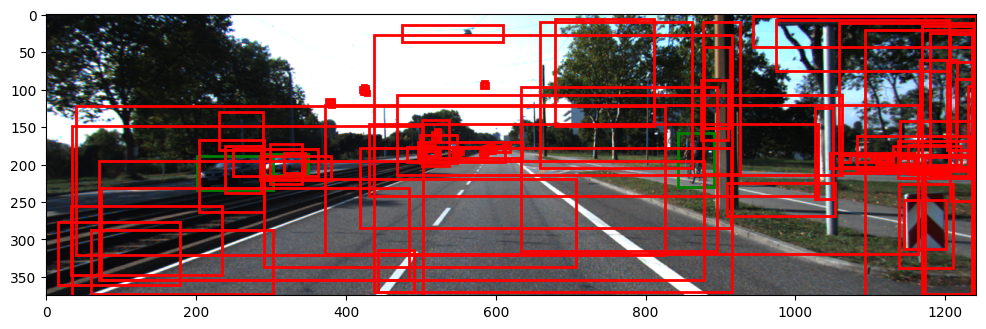

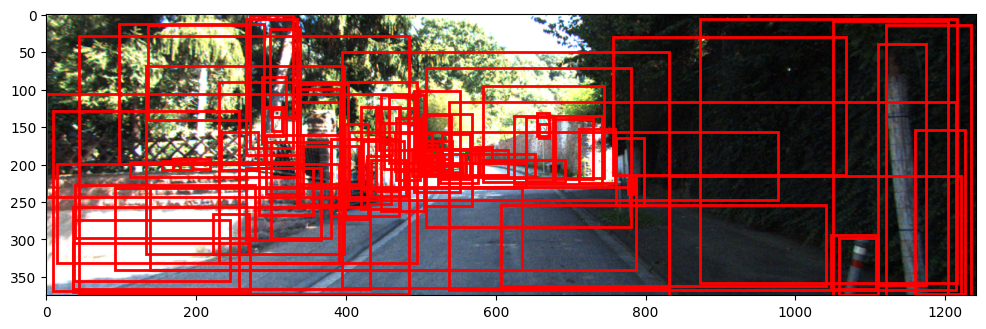

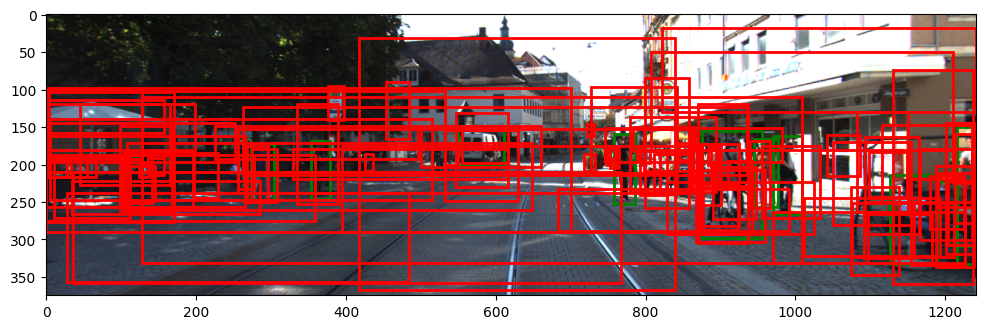

Epoch 1/10:   0%|          | 0/76 [01:16<?, ?it/s, loss=2.96]


KeyboardInterrupt: 

In [7]:
#Train.py
from tqdm import tqdm
import os
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
save_path = '/content/drive/MyDrive/Object Detection of Images CV Project'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize tqdm progress bar
    pbar = tqdm(enumerate(data_loader_train), total=len(data_loader_train), desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)

    for batch_idx, (images, targets) in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

        # Update tqdm progress bar
        pbar.set_postfix({'loss': running_loss / (batch_idx + 1)})

        # Visualize the first batch of each epoch
        if batch_idx == 0:
            model.eval()
            with torch.no_grad():
                predictions = model(images)
            for i in range(len(images)):
                visualize_image(images[i], target=targets[i], prediction=predictions[i])
            model.train()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(data_loader_train)}")

    # Save model checkpoint after each epoch
    torch.save(model.state_dict(), os.path.join(save_path, f"fasterrcnn_resnet50_fpn_epoch_{epoch + 1}.pth"))

print("Training complete.")


In [8]:
#Testing.py

#NOTE: Please don't be confused because I have written some code segments repeatedly like: Dataset Loading and Model Loading
#because some error came and i have to do it like this

import torch
import torchvision
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define KITTI_CLASSES if not defined elsewhere
KITTI_CLASSES = ['__background__', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

# Define metric calculation functions
def calculate_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    accuracy = accuracy_score(true_labels, pred_labels)
    return accuracy, precision, recall, f1

# Function to apply NMS
def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = {}
    final_prediction['boxes'] = orig_prediction['boxes'][keep]
    final_prediction['scores'] = orig_prediction['scores'][keep]
    final_prediction['labels'] = orig_prediction['labels'][keep]
    return final_prediction

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            nms_outputs = [apply_nms(output) for output in outputs]

            for target, nms_output in zip(targets, nms_outputs):
                true_labels = target["labels"].tolist()
                pred_labels = nms_output["labels"].tolist()

                # Extend the lists only if there are predictions
                if pred_labels:
                    all_true_labels.extend(true_labels)
                    all_pred_labels.extend(pred_labels)

    # Ensure that the lengths are the same
    min_len = min(len(all_true_labels), len(all_pred_labels))
    all_true_labels = all_true_labels[:min_len]
    all_pred_labels = all_pred_labels[:min_len]

    # Calculate metrics
    accuracy, precision, recall, f1 = calculate_metrics(all_true_labels, all_pred_labels)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Load the trained model (make sure the model path is correct)
model_path = '/content/drive/My Drive/Object Detection of Images CV Project/Best_Final_Model.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def load_model(model_path, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = len(KITTI_CLASSES)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model = load_model(model_path, device)

# Dataset definition
class KITTIDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.anns = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "labels", self.anns[idx])
        img = Image.open(img_path).convert("RGB")
        with open(ann_path, 'r') as f:
            data = f.readlines()
        boxes = []
        labels = []
        for line in data:
            parts = line.strip().split()
            class_name = parts[0]
            bbox = list(map(float, parts[4:8]))
            if class_name in KITTI_CLASSES:
                labels.append(KITTI_CLASSES.index(class_name))
                boxes.append(bbox)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

# Transforms
def get_transform():
    transforms = [
        T.ToTensor(),
    ]
    return T.Compose(transforms)

# Create dataset and dataloader
dataset = KITTIDataset(root='/content/drive/MyDrive/Object Detection of Images CV Project', transforms=get_transform())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Evaluate the model
evaluate(model, data_loader_test, device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 0.5728
Precision: 0.5505
Recall: 0.5728
F1 Score: 0.5609


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-11-6b212e82a50d>:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize(text)


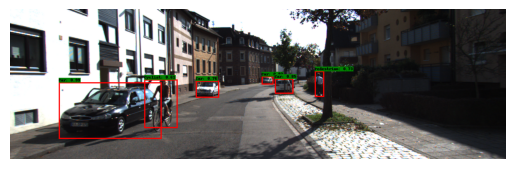

In [11]:
#Inference.py

import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T
import torchvision.ops as ops
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Define KITTI_CLASSES here if not defined elsewhere
KITTI_CLASSES = ['__background__', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram']

def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = {}
    final_prediction['boxes'] = orig_prediction['boxes'][keep]
    final_prediction['scores'] = orig_prediction['scores'][keep]
    final_prediction['labels'] = orig_prediction['labels'][keep]

    return final_prediction

def infer_image(image_path, model, device, threshold=0.5):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Process the outputs
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    outputs = [apply_nms(output) for output in outputs]
    boxes = outputs[0]['boxes']
    scores = outputs[0]['scores']
    labels = outputs[0]['labels']

    # Draw the boxes and labels on the image
    draw = ImageDraw.Draw(image)
    # Use the default PIL font
    font = ImageFont.load_default()

    for box, score, label in zip(boxes, scores, labels):
        if score > threshold:
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)
            # Increase the font size by scaling
            text = f"{KITTI_CLASSES[label]}: {score:.2f}"
            text_size = font.getsize(text)
            text_position = (xmin, ymin - text_size[1])
            draw.rectangle([text_position, (xmin + text_size[0], ymin)], fill='green')
            draw.text(text_position, text, fill='black', font=font)

    return image

# Path to the saved model weights in Google Drive
model_path = '/content/drive/My Drive/Object Detection of Images CV Project/Best_Final_Model.pth'

# Function to load model weights
def load_model(model_path, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    num_classes = 8  # Assuming 8 classes for KITTI

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load the trained model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = load_model(model_path, device)

image_path = '/content/drive/My Drive/Object Detection of Images CV Project/infer_image/image5.png'

# Inference on an example image
result_image = infer_image(image_path, model, device)

# Generate a unique name for the result image
unique_name = f"result_image_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
result_image_save_path = os.path.join('/content/drive/My Drive/Object Detection of Images CV Project', unique_name)

# Save the result image
result_image.save(result_image_save_path)

# Display the result image in Google Colab
plt.imshow(result_image)
plt.axis('off')
plt.show()
